# Convolutional Neural Network Using MFCC Classifying Emotion In Female Samples

Garrett Faucher

In [1]:
from keras.callbacks import EarlyStopping
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

## Data Processing

In [2]:
audio_data = np.load("../data/audio_data_long.npy")
labels = np.load("../data/wav_labels.npy")
NUM_SAMPLES = 1440
MFCC_X = 1515
MFCC_Y = 30

# labels: modality-vocal channel-emotion-emotional intensity-statement-repetition-actor
# emotions: 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
# odd number actors = male, even = female

# 1440 files: 24 speakers, 60 recordings per speaker
audio_data = audio_data.reshape(NUM_SAMPLES, MFCC_X * MFCC_Y)

features = []

for i in range(1440):
    if (labels[i][6]%2 == 0):
        label = "Female"
    else:
        label = "Male"
    features.append([audio_data[i], label, int(labels[i][2])-1])
    
feature_df = pd.DataFrame(features, columns = ["mfcc", "gender", "emotion"])

feature_df.head()

,mfcc,gender,emotion
0,"[-753.9097900390625, -753.65185546875, -749.87...",Female,0
1,"[-572.5694580078125, -573.3067626953125, -570....",Female,2
2,"[-668.666015625, -667.28857421875, -666.047302...",Female,7
3,"[-778.8489379882812, -778.4188842773438, -778....",Female,1
4,"[-734.869873046875, -733.115234375, -737.47387...",Female,4


In [3]:
#split data - females
fem = feature_df.loc[feature_df['gender'] == "Female"]

## ===== Females ===== ##
X_females_unscaled = np.array(fem.mfcc.tolist())
y_females = np.array(fem.emotion.tolist())

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(X_females_unscaled)
X_females_scaled = scaler.transform(X_females_unscaled)

#20-80 train-test split
X_train_females, X_test_females, y_train_females, y_test_females = train_test_split(X_females_scaled, y_females, test_size=0.20, random_state=0)

# Reshape for CNN input
X_train_females = np.array([x.reshape( (MFCC_X, MFCC_Y, 1) ) for x in X_train_females])
X_test_females = np.array([x.reshape( (MFCC_X, MFCC_Y, 1) ) for x in X_test_females])

# One-Hot encoding for classes
y_train_females = np.array(to_categorical(y_train_females, 8))
y_test_females = np.array(to_categorical(y_test_females, 8))

## CNN Architechture

In [4]:
model = Sequential()

model.add(Conv2D(64, (5,5), input_shape=X_test_females.shape[1:], kernel_regularizer=l2(l=0.01)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(24, (4,4)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate=0.1))

model.add(Conv2D(24, (3,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate=0.2))

model.add(Conv2D(80, (2,2)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate=0.5))

model.add(Flatten())
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(rate=0.5))
model.add(Dense(8))
model.add(Activation('softmax'))

In [5]:
opt = Adam(learning_rate=0.0005)

model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy']
)

history = model.fit(
	x=X_train_females,
	y=y_train_females,
    epochs=150,
    batch_size=75,
    validation_data=(X_test_females, y_test_females),
	callbacks=[EarlyStopping(monitor='loss', patience=7)],
	verbose=0
)

y_pred = model.predict(X_test_females)

score = model.evaluate(
	x=X_test_females,
	y=y_test_females)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

5/5 [==============================] - 0s 21ms/step - loss: 1.2848 - accuracy: 0.7153
Test loss: 1.284770131111145
Test accuracy: 0.7152777910232544


## Analysis

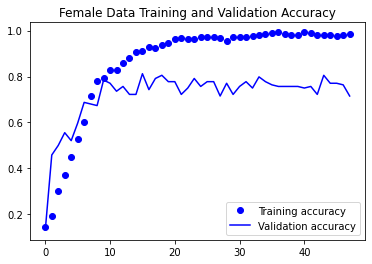

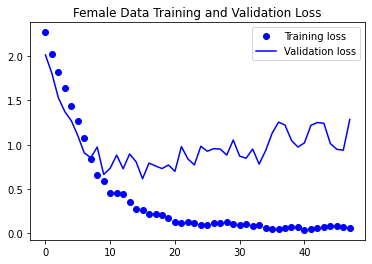

In [6]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Female Data Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Female Data Training and Validation Loss')
plt.legend()
plt.show()

CNN Female Emotion Classification
   0   4  3   2   0   2   3   4
0  3   0  1   5   0   0   0   0
1  2  13  0   1   0   2   2   0
2  0   0  9   1   1   1   0   1
3  0   0  2  13   0   1   2   0
4  0   0  1   1  15   0   2   0
5  0   0  1   1   0  18   0   0
6  0   1  0   2   1   0  17   0
7  0   0  3   2   3   1   0  15


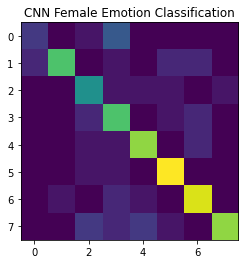

In [7]:
#Algorithm Evaluation
cm = confusion_matrix(y_test_females.argmax(axis=1), y_pred.argmax(axis=1))
print("CNN Female Emotion Classification")
df = pd.DataFrame(cm, columns=[y_females[0], y_females[4], y_females[12], y_females[20], y_females[28], y_females[36], y_females[44], y_females[52] ])
print(df)

#figure for confusion matrix
cm = confusion_matrix(y_test_females.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10,4))
plt.imshow(cm)
plt.title("CNN Female Emotion Classification")
plt.show()

#precision function
def precision(confmatrix):
    # precision = tp/(tp+fp)
    tp = np.diag(confmatrix)
    fp = np.sum(confmatrix, axis=0) - tp
    precision = np.mean(tp/(tp+fp))
    return precision

prec = precision(cm)

emotions: 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised